# 4.6.2 Creación de modelos
## Configuración inicial

### Importando librerías y cargando los datos

In [1]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['axes.grid'] = False

from keras.datasets import imdb
from keras import models, layers, optimizers

import json, os

In [2]:
data_file = os.getcwd() + "/in_models/historical_data_to_model_2.csv"
df = pd.read_csv(data_file, low_memory=False)
label = 'AQI'
df.shape

(17141, 21)

In [3]:
OUT_STEPS = 3
INPUT_WIDTH = 24 

In [4]:
df.columns

Index(['AQI', 'weekday', 'speed', 'travel_time', 'Minimum Temperature',
       'Maximum Temperature', 'Temperature', 'Dew Point', 'Relative Humidity',
       'Precipitation', 'Snow Depth', 'Visibility', 'Cloud Cover',
       'Sea Level Pressure', 'Conditions', 'Wx', 'Wy', 'Day sin', 'Day cos',
       'Year sin', 'Year cos'],
      dtype='object')

### División de los datos
Se hace una división (70%, 20%, 10%) para los conjuntos de entrenamiento, validación y prueba respectivamente.

In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [6]:
print("Train: ", train_df.shape)
print("Validation: ", val_df.shape)
print("Test: ", test_df.shape)

Train:  (11998, 21)
Validation:  (3428, 21)
Test:  (1715, 21)


### Normalizar los datos
Se guardan los datos de entreno en un CSV aparte, ya que estos son los datos que se utilizarán para normalizar cualquier dato que se le proporcione al modelo.

### IMPORTANTE
Este documento es el utilizado por los métodos reponsables de reentrenar y ejecutar los modelos en tiempo real para normalizar los datos

In [7]:
train_path = os.getcwd().split("TFG")[0] + "TFG\\in\\normalize_data\\train_data_all_models.csv"
train_df.to_csv(train_path, index=False)

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Ventana de datos
Los modelos de este estudio harán un conjunto de predicciones basadas en una ventana de muestras consecutivas de los datos.

Esta sección se centra en implementar la ventana de datos para que pueda reutilizarse para todos los modelos.

El resto de esta sección define una clase `WindowGenerator` . Esta clase permite:

 1. Manejar los índices y compensaciones.
 2. Dividir las ventanas de entidades en pares (features, labels).
 3. Trazar el contenido de las ventanas resultantes.
 4. Generar de manera eficiente lotes de estas ventanas a partir de los datos de entrenamiento, evaluación y prueba, utilizando `tf.data.Datasets`.

### 1. Índices y compensaciones
Se crea la clase `WindowGenerator`. El método `__init__` incluye toda la lógica necesaria para los índices de entrada y etiqueta.

También toma los marcos de datos de entrenamiento, validación y prueba como entrada. Estos se convertirán a `tf.data.Datasets` de Windows más adelante.

In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### 2. Split / Dividir
Dada una lista de entradas consecutivas, el método `split_window` la convertirá en una ventana de entradas y una ventana de etiquetas.

In [10]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

### 3. Plot
Método de trazado que permite una visualización simple de la ventana dividida:

In [11]:
def plot(self, model=None, plot_col=label, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(10, 6))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
            
    plt.xlabel('Time [h]')
    plt.show()
    

WindowGenerator.plot = plot

 El método `plot loss` sirve para graficar los valores de perdida en la fase de entreno y validación para ayudar a identificar si hay overfitting o underfitting

In [12]:
def plot_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    fig = plt.figure(figsize=(5,5))
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,loss_values, 'o',label='training')
    plt.plot(epoch,val_loss_values, '--',label='val')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    
WindowGenerator.plot_loss = plot_loss

### 4. tf.data.Datasets
Finalmente, el método `make_dataset` tomará una serie de tiempo `DataFrame`  y lo convertirá en un `tf.data.Dataset` de `(input_window, label_window)` usando la función `preprocessing.timeseries_dataset_from_array`.

In [13]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,
      )
    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

El objeto `WindowGenerator` contiene datos de entrenamiento, validación y prueba. Se agregan propiedades para acceder a ellas como `tf.data.Datasets` usando el método `make_dataset` anterior.

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### 5. Estadísticas
El método `model_statistics` imprime en pantalla infromación relevante del modelo. 
Los diccionarios declarados se utilizan para guardar los resultados de las pruebas para cada modelo.

In [15]:
multi_val_performance = {}
multi_test_performance = {}

In [16]:
def model_statistics(model, history, name):  
    print("General statistics of the generated model:")
    multi_val_performance[f'{name} {multi_window.input_width}h'] = model.evaluate(multi_window.val)
    print("Statistics of the model with the test data:")
    multi_test_performance[f'{name} {multi_window.input_width}h'] = model.evaluate(multi_window.test)
    print('Model\'s Training and Validation Loss: ')
    plot_loss(history)
    print('Predictions: ')
    multi_window.plot(model)

## Creación de los modelos

Para estos modelos, los datos de entrenamiento constan de muestras por hora. Aquí, los modelos aprenderán a predecir  3 horas del futuro, dadas 24 horas del pasado (indicadas en la variable `input_width`).

Se genera el objeto Window que creará los cortes a partir del conjunto de datos, con los que se entrenaran los modelos en cuestión:

In [17]:
multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

Se crea el método `compile_and_fit` que se utilizará para compilar y entrenar los modelos que se irán proponiendo a lo largo de este documento.

In [18]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    # The patience parameter is the amount of epochs to check for improvement
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanAbsoluteError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])

    return history

### 1. Modelo base

In [19]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [20]:
print("Estadísticas generales del modelo entrenado:")
multi_val_performance[f'Baseline {multi_window.input_width}h'] = last_baseline.evaluate(multi_window.val)
print("Estadísticas del modelo con los datos de test:")
multi_test_performance[f'Baseline {multi_window.input_width}h'] = last_baseline.evaluate(multi_window.test)

Estadísticas generales del modelo entrenado:
107/107 [==============================] - 0s 2ms/step - loss: 0.1922 - mean_absolute_error: 0.2185
Estadísticas del modelo con los datos de test:
53/53 [==============================] - 0s 3ms/step - loss: 0.3053 - mean_absolute_error: 0.2747


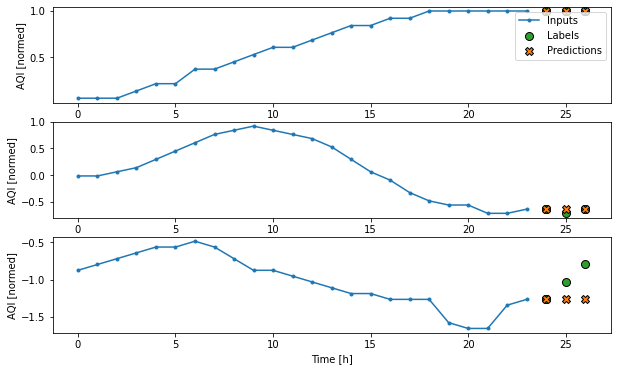

In [21]:
multi_window.plot(last_baseline)

### 2. Modelo lineal

In [22]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_linear_model, multi_window)
IPython.display.clear_output()


General statistics of the generated model:
107/107 [==============================] - 0s 519us/step - loss: 0.1712 - mean_absolute_error: 0.1712
Statistics of the model with the test data:
53/53 [==============================] - 0s 577us/step - loss: 0.2239 - mean_absolute_error: 0.2239
Model's Training and Validation Loss: 


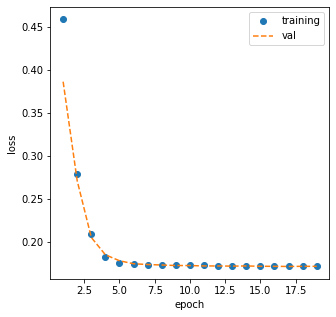

Predictions: 


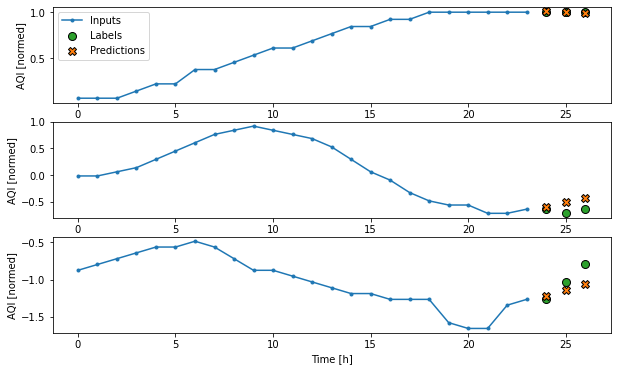

In [23]:
model_statistics(multi_linear_model, history, "Linear")

In [24]:
pd.DataFrame(history.history)

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.458945,0.458945,0.386308,0.386308
1,0.278678,0.278678,0.270686,0.270686
2,0.208413,0.208413,0.204784,0.204784
3,0.181833,0.181833,0.184568,0.184568
4,0.175204,0.175204,0.177643,0.177643
5,0.173643,0.173643,0.174131,0.174131
6,0.173006,0.173006,0.173257,0.173258
7,0.172668,0.172668,0.172680,0.172680
8,0.172363,0.172363,0.172093,0.172093
9,0.172274,0.172274,0.172059,0.172059


### 3. Modelo denso

In [25]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(256, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)
IPython.display.clear_output()

General statistics of the generated model:
107/107 [==============================] - 0s 575us/step - loss: 0.1778 - mean_absolute_error: 0.1778
Statistics of the model with the test data:
53/53 [==============================] - 0s 558us/step - loss: 0.2437 - mean_absolute_error: 0.2437
Model's Training and Validation Loss: 


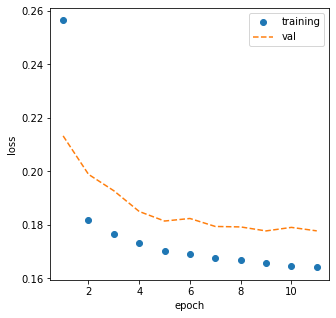

Predictions: 


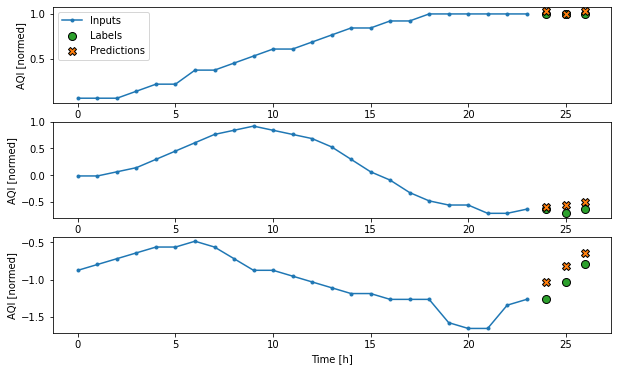

In [26]:
model_statistics(multi_dense_model, history, "Dense")

In [27]:
pd.DataFrame(history.history)

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.256436,0.256436,0.213266,0.213266
1,0.181687,0.181687,0.198909,0.198909
2,0.176548,0.176548,0.192769,0.192769
3,0.173309,0.173309,0.185030,0.185030
4,0.170148,0.170149,0.181465,0.181465
5,0.168991,0.168991,0.182415,0.182415
6,0.167507,0.167507,0.179435,0.179435
7,0.166759,0.166759,0.179263,0.179263
8,0.165599,0.165599,0.177771,0.177771
9,0.164769,0.164769,0.179089,0.179089


### 4. Modelo CNN


In [28]:
CONV_WIDTH = 3
multi_conv_model_1 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model_1, multi_window)
IPython.display.clear_output()

General statistics of the generated model:
107/107 [==============================] - 0s 575us/step - loss: 0.1871 - mean_absolute_error: 0.1871
Statistics of the model with the test data:
53/53 [==============================] - 0s 596us/step - loss: 0.2541 - mean_absolute_error: 0.2541
Model's Training and Validation Loss: 


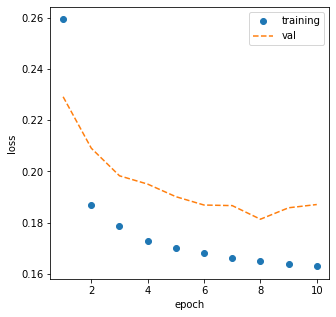

Predictions: 


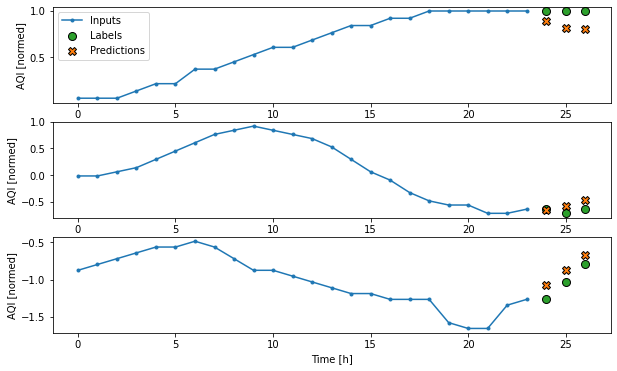

In [29]:
model_statistics(multi_conv_model_1, history, "Conv")

In [30]:
pd.DataFrame(history.history)

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.259450,0.259450,0.229188,0.229188
1,0.186998,0.186998,0.209077,0.209077
2,0.178596,0.178596,0.198301,0.198301
3,0.172676,0.172676,0.195054,0.195054
4,0.170152,0.170152,0.190142,0.190142
5,0.168097,0.168097,0.186876,0.186876
6,0.166162,0.166162,0.186651,0.186651
7,0.165177,0.165177,0.181333,0.181333
8,0.163680,0.163680,0.185804,0.185804
9,0.162873,0.162873,0.187075,0.187075


Se prueba el mismo modelo pero con menos neuronas en la segunda capa

In [31]:
CONV_WIDTH = 3
multi_conv_model_2 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model_2, multi_window)
IPython.display.clear_output()

General statistics of the generated model:
107/107 [==============================] - 0s 538us/step - loss: 0.1799 - mean_absolute_error: 0.1799
Statistics of the model with the test data:
53/53 [==============================] - 0s 577us/step - loss: 0.2455 - mean_absolute_error: 0.2455
Model's Training and Validation Loss: 


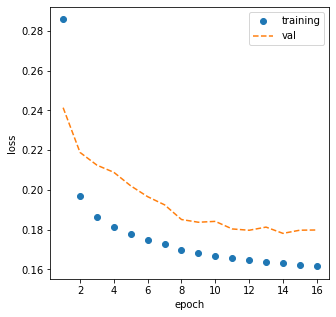

Predictions: 


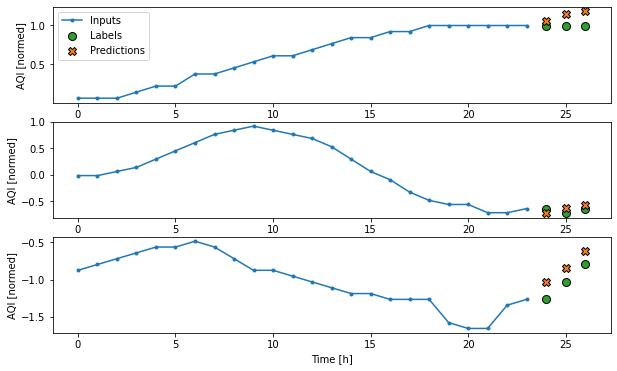

In [32]:
model_statistics(multi_conv_model_2, history, "Conv")

In [33]:
pd.DataFrame(history.history)

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.285826,0.285826,0.241393,0.241393
1,0.196879,0.196878,0.218879,0.218879
2,0.186210,0.186210,0.212472,0.212472
3,0.181328,0.181328,0.208875,0.208875
4,0.177743,0.177743,0.202069,0.202069
5,0.174813,0.174813,0.196621,0.196621
6,0.172594,0.172594,0.192520,0.192520
7,0.169578,0.169578,0.185136,0.185136
8,0.168136,0.168136,0.183764,0.183765
9,0.166723,0.166723,0.184206,0.184206


### 5. Modelo RNN


In [34]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)
IPython.display.clear_output()

General statistics of the generated model:
107/107 [==============================] - 0s 2ms/step - loss: 0.1908 - mean_absolute_error: 0.1908
Statistics of the model with the test data:
53/53 [==============================] - 0s 2ms/step - loss: 0.2225 - mean_absolute_error: 0.2225
Model's Training and Validation Loss: 


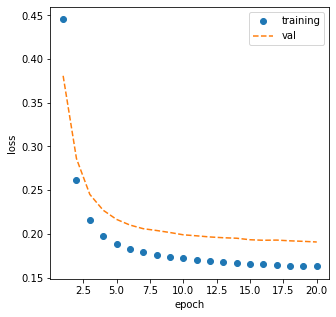

Predictions: 


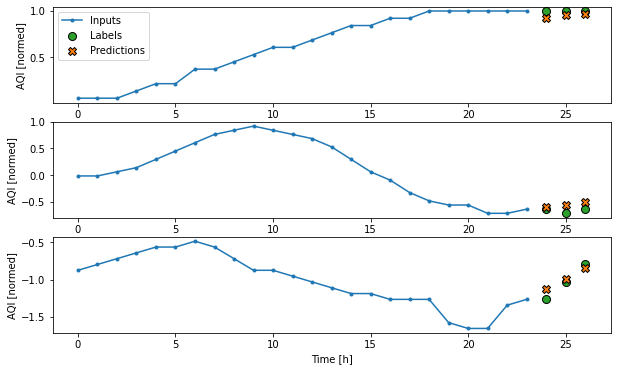

In [35]:
model_statistics(multi_lstm_model, history, "LSTM")

In [36]:
pd.DataFrame(history.history)

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.445378,0.445378,0.380817,0.380817
1,0.261660,0.261660,0.286079,0.286079
2,0.216055,0.216055,0.245154,0.245154
3,0.197693,0.197693,0.227085,0.227085
4,0.188423,0.188423,0.216621,0.216621
5,0.182926,0.182926,0.210170,0.210170
6,0.178946,0.178946,0.205976,0.205976
7,0.176184,0.176184,0.203907,0.203907
8,0.174067,0.174067,0.201607,0.201607
9,0.172218,0.172218,0.198985,0.198985


Se guardan los modelos y sus estadísticas:

In [37]:
models_path = os.getcwd().split("models_analysis")[0] + "all_models\\new_models"

In [38]:
multi_linear_model.save(f'{models_path}/multi_linear_model_input_{INPUT_WIDTH}_out_{OUT_STEPS}.h5')
multi_dense_model.save(f'{models_path}/multi_dense_model_input_{INPUT_WIDTH}_out_{OUT_STEPS}.h5')
multi_conv_model_1.save(f'{models_path}/multi_conv_model_1_input_{INPUT_WIDTH}_out_{OUT_STEPS}.h5')
multi_conv_model_2.save(f'{models_path}/multi_conv_model_2_input_{INPUT_WIDTH}_out_{OUT_STEPS}.h5')
multi_lstm_model.save(f'{models_path}/multi_lstm_model_input_{INPUT_WIDTH}_out_{OUT_STEPS}.h5')

In [39]:
multi_performance = {'Validation': multi_val_performance, 'Test': multi_test_performance}
tf = open(f"{models_path}/statistics/statistics_input_width_{INPUT_WIDTH}_out_steps_{OUT_STEPS}.json", "w")
json.dump(multi_performance,tf)
tf.close()

Referencias: Apache License, Version 2.0 . (17 de 06 de 2021). Time series forecasting  |  TensorFlow Core. Obtenido de TensorFlow: https://www.tensorflow.org/tutorials/structured_data/time_series